In [1]:
import os, sys, time
# Reference: https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload

import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import homogeneity_score


import common
import DimensionalityReduction.DimensionalityReductionDatasets as dr_datasets
from data.generated.generated_data import get_noisy_nonlinear_with_non_noisy_labels

title_fontsize = 24
fontsize = 24
legend_fontsize = 18
default_figure_size = (15, 8)

DATASET = "Generated Non-Linear"

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [2]:
X_train_gnnl, X_test_gnnl, y_train_gnnl, y_test_gnnl, y_test_non_noisy_gnnl =\
get_noisy_nonlinear_with_non_noisy_labels()

reload(dr_datasets)
boosted_gnnl = dr_datasets.get_gnnl_boosted_best_features()

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [3]:
boosted_gnnl.shape[1]

5

In [4]:
reload(common)
n = boosted_gnnl.shape[1]
distortions, davies_bouldin_scores, silhouette_scores, calinski_harabasz_scores, times =\
common.compute_kmeans_scores(boosted_gnnl, n)

For n_clusters = 2 average silhouette_score: 0.7148495471018003 time taken: 0.11173295974731445s
For n_clusters = 3 average silhouette_score: 0.60613603903159 time taken: 0.09385013580322266s
For n_clusters = 4 average silhouette_score: 0.6243370095724315 time taken: 0.09327125549316406s
For n_clusters = 5 average silhouette_score: 0.4982477668747232 time taken: 0.24542832374572754s


/media/richard/Data/CloudStation/Masters Degree/GATechOMSCS_CourseWork/CS7641-Machine_Learning/UnsupervisedLearning_Project_Code/common.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  host = fig.add_subplot(111)


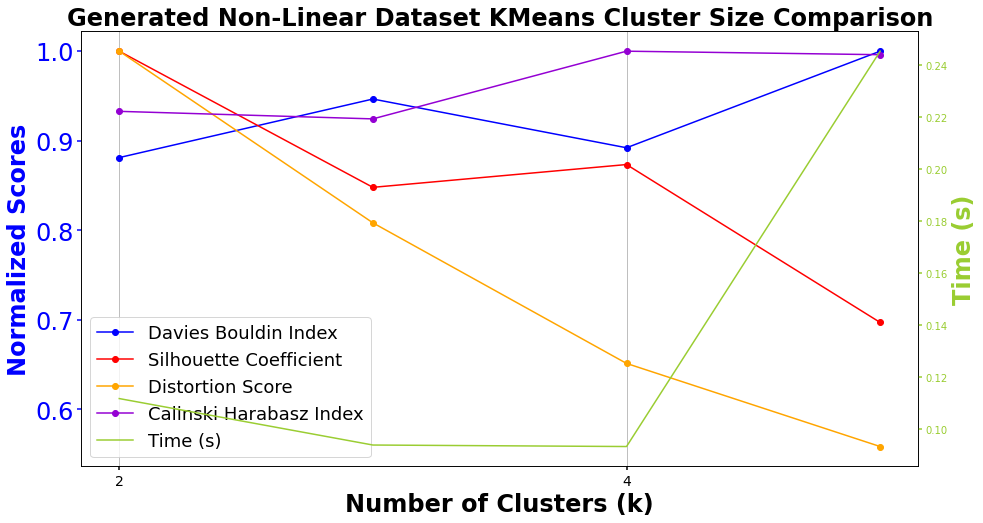

In [5]:
common.plot_kmeans_all(distortions, davies_bouldin_scores, silhouette_scores, calinski_harabasz_scores, times, DATASET)

/media/richard/Data/CloudStation/Masters Degree/GATechOMSCS_CourseWork/CS7641-Machine_Learning/UnsupervisedLearning_Project_Code/common.py:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  host = fig.add_subplot(111)


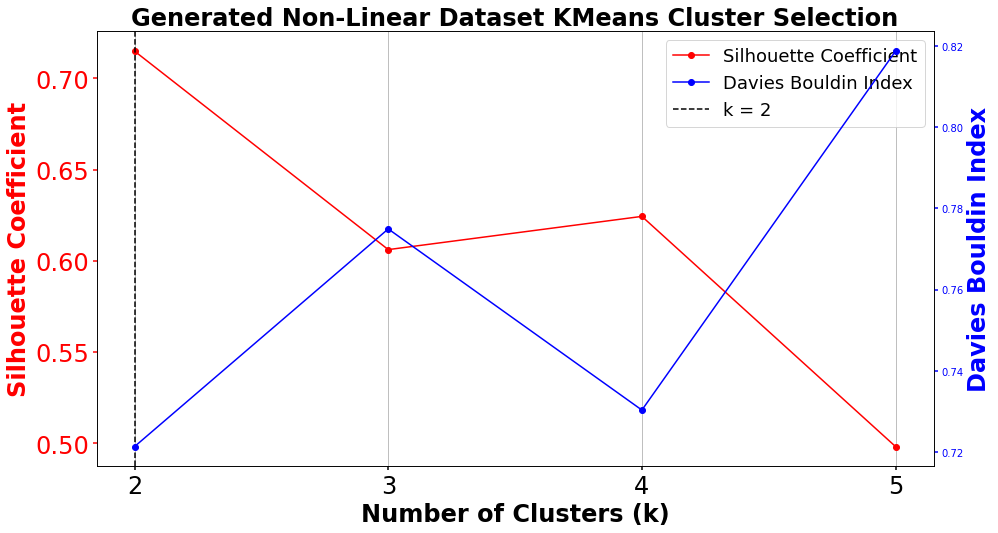

In [6]:
reload(common)
best_k = 2
common.plot_kmeans_selection(davies_bouldin_scores, silhouette_scores, best_k=best_k, DATASET=DATASET, tick_spacing=1)

For n_clusters = 2 average silhouette_score: 0.7148495471018003 time taken: 0.6467502117156982s


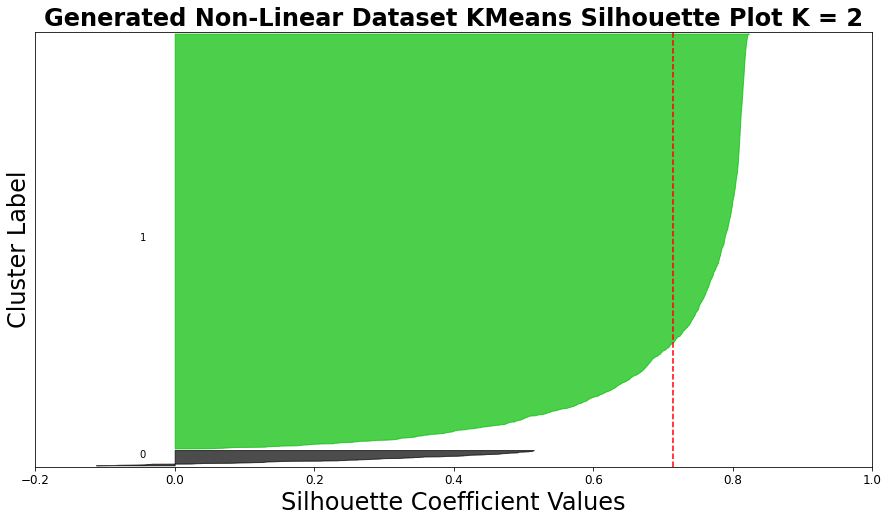

In [7]:
reload(common)
common.plot_silhouette_kmeans(boosted_gnnl, best_k, DATASET, xlim=[-0.2, 1.0])

In [12]:
y_train_gnnl_df = pd.DataFrame(y_train_gnnl, columns=["data_labels"])

start_time = time.time()
km = KMeans(n_clusters=best_k, **common.km_arguements)
km.fit(boosted_gnnl)
end_time = time.time()
print("Time Taken {} s".format(end_time - start_time))
y_train_gnnl_df['km_labels']=km.labels_
boosted_gnnl_km = pd.DataFrame(boosted_gnnl.copy())
boosted_gnnl_km['km_labels'] = km.labels_
boosted_gnnl_km['data_labels'] = y_train_gnnl_df['data_labels']

print("homogeneity_score: ", homogeneity_score(km.labels_, y_train_gnnl))

Time Taken 0.1378004550933838 s
homogeneity_score:  0.007196183938076611


In [9]:
# Create a t-SNE model with learning rate 50
m = TSNE(perplexity=30, learning_rate=50)

# Fit and transform the t-SNE model on the numeric dataset
tsne_features = m.fit_transform(boosted_gnnl)
y_train_gnnl_df['x'] = tsne_features[:,0]
y_train_gnnl_df['y'] = tsne_features[:,1]

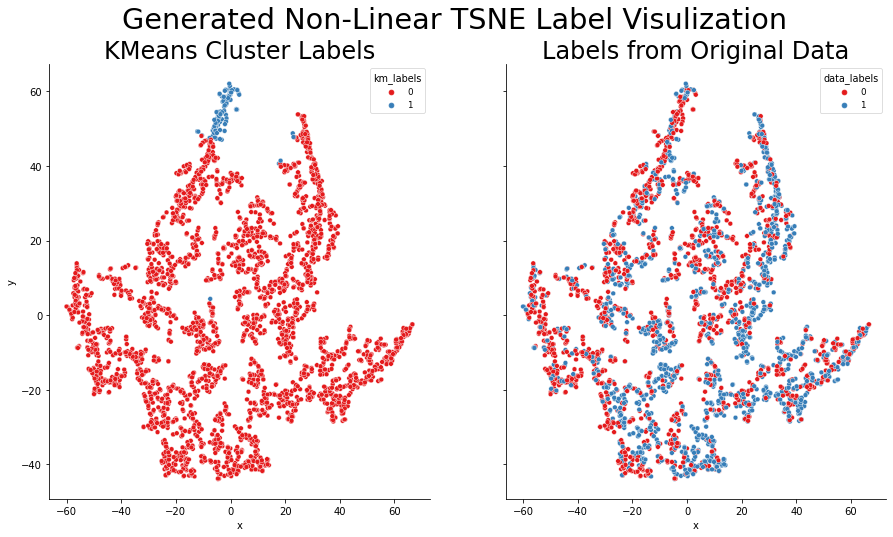

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=default_figure_size, sharey=True)

sns.set_context("paper", rc={"font.size": fontsize, "axes.titlesize": fontsize, "axes.labelsize": fontsize})

sns.scatterplot(x="x", y="y", hue="km_labels", data=y_train_gnnl_df, palette="Set1", ax=ax1)
sns.scatterplot(x="x", y="y", hue="data_labels", data=y_train_gnnl_df, palette="Set1", ax=ax2)

fig.suptitle("{} TSNE Label Visulization".format(DATASET))
ax1.set_title("KMeans Cluster Labels")
ax2.set_title("Labels from Original Data")
sns.despine(fig)

plt.show()

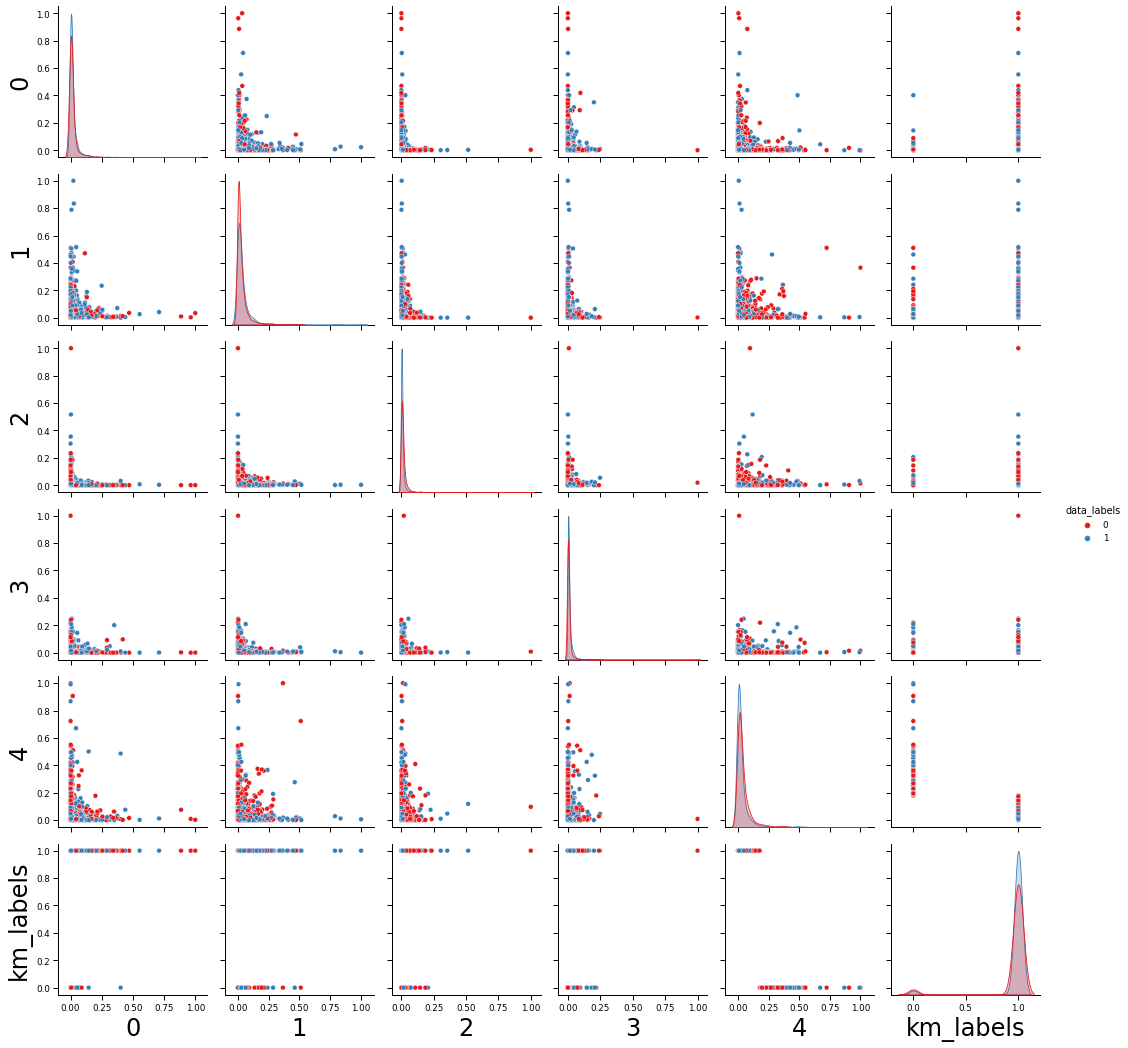

In [13]:
sns.pairplot(boosted_gnnl_km, hue="data_labels", palette="Set1")

# Expectation Maximization

In [14]:
reload(common)
em_n = boosted_gnnl.shape[1]
n_components = np.arange(2, em_n)
davies_bouldin_scores_em, silhouette_scores_em, bic_scores_em, aic_scores_em, times_em =\
common.compute_em_scores(boosted_gnnl, em_n)

For n_clusters = 2 average silhouette_score: 0.15994827486000557 time taken: 0.15130209922790527s
For n_clusters = 3 average silhouette_score: 0.14780590497571033 time taken: 0.18589401245117188s
For n_clusters = 4 average silhouette_score: 0.09143347523663108 time taken: 0.22455263137817383s
For n_clusters = 5 average silhouette_score: 0.07195838760228856 time taken: 0.32525062561035156s


/media/richard/Data/CloudStation/Masters Degree/GATechOMSCS_CourseWork/CS7641-Machine_Learning/UnsupervisedLearning_Project_Code/common.py:250: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  host = fig.add_subplot(111)


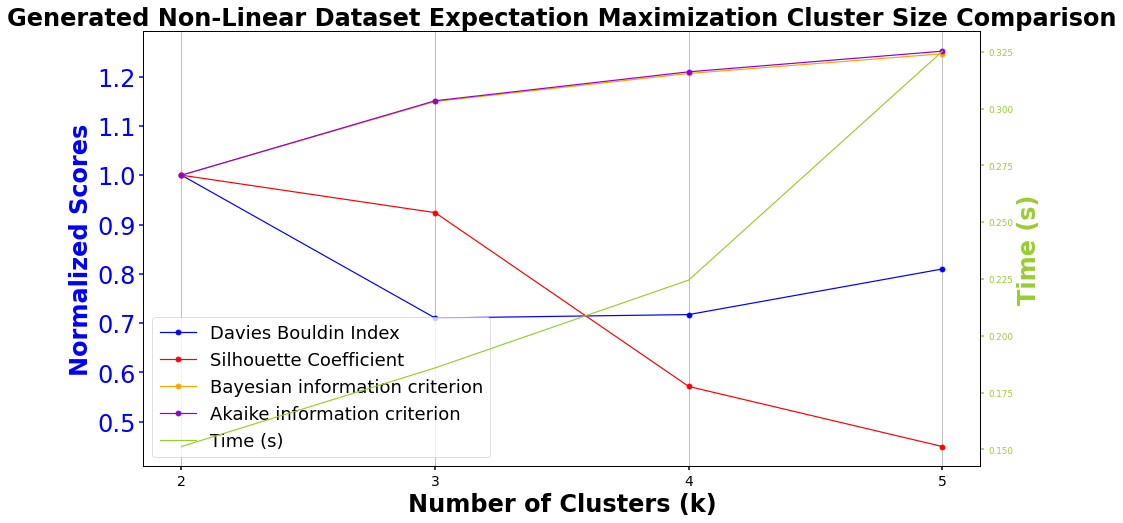

In [15]:
reload(common)
common.plot_em_all(davies_bouldin_scores_em, silhouette_scores_em, bic_scores_em, aic_scores_em, times_em, DATASET)

/media/richard/Data/CloudStation/Masters Degree/GATechOMSCS_CourseWork/CS7641-Machine_Learning/UnsupervisedLearning_Project_Code/common.py:301: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  host = fig.add_subplot(111)


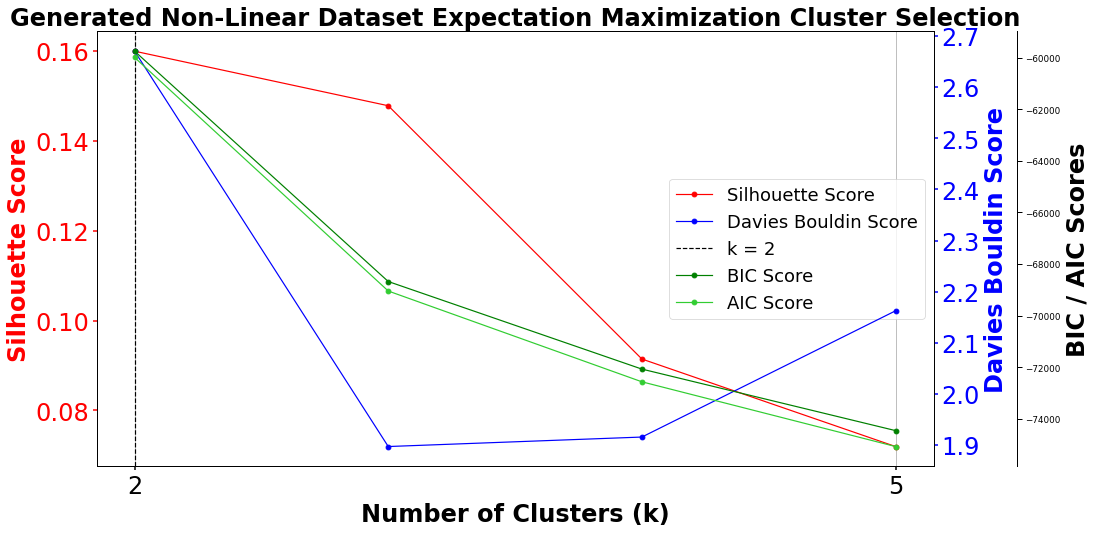

In [20]:
reload(common)
best_k = 2
common.plot_em_selection(davies_bouldin_scores_em, silhouette_scores_em, bic_scores_em, aic_scores_em, best_k, DATASET, tick_spacing=3)

For n_clusters = 2 average silhouette_score: 0.15994827486000557 time taken: 0.15227222442626953s


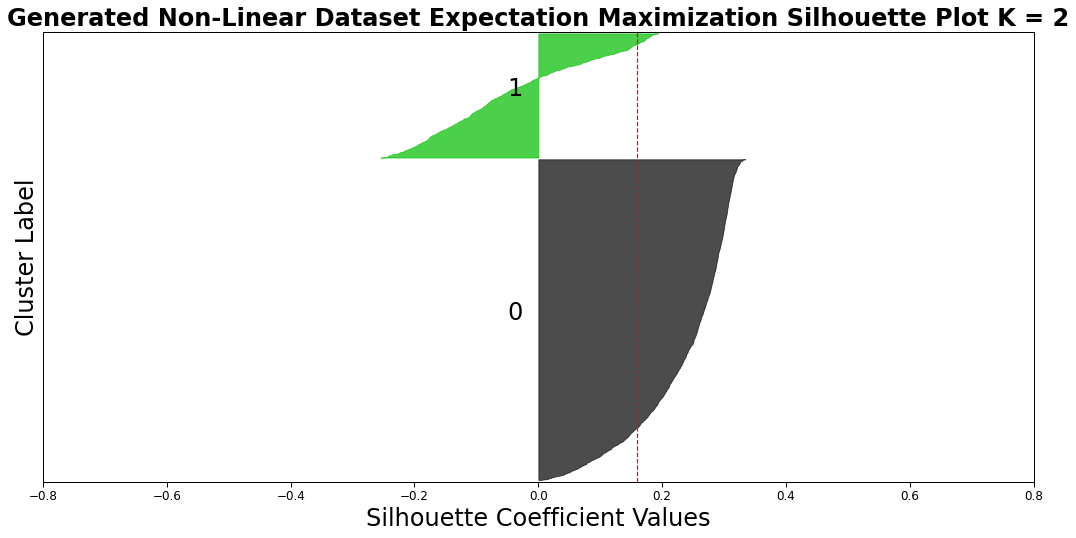

In [21]:
reload(common)
best_k=2
common.plot_silhouette_em(boosted_gnnl, best_k, DATASET, xlim=[-0.8, 0.8])

In [22]:
y_train_gnnl_df = pd.DataFrame(y_train_gnnl, columns=["data_labels"])

start_time = time.time()
em_model = GaussianMixture(best_k, **common.em_arguements)
em_model.fit(boosted_gnnl)
end_time = time.time()
print("time taken {} s".format(end_time-start_time))
y_train_gnnl_df['em_labels']=em_model.predict(boosted_gnnl)
boosted_gnnl_em = pd.DataFrame(boosted_gnnl.copy())
boosted_gnnl_em['em_labels'] = em_model.predict(boosted_gnnl)

print("homogeneity_score: ", homogeneity_score(em_model.predict(boosted_gnnl), y_train_gnnl))


time taken 0.1602168083190918 s
homogeneity_score:  0.015049864764771187


In [23]:
# Create a t-SNE model with learning rate 50
m = TSNE(perplexity=30, learning_rate=50)

# Fit and transform the t-SNE model on the numeric dataset
tsne_features = m.fit_transform(boosted_gnnl)
y_train_gnnl_df['x'] = tsne_features[:,0]
y_train_gnnl_df['y'] = tsne_features[:,1]

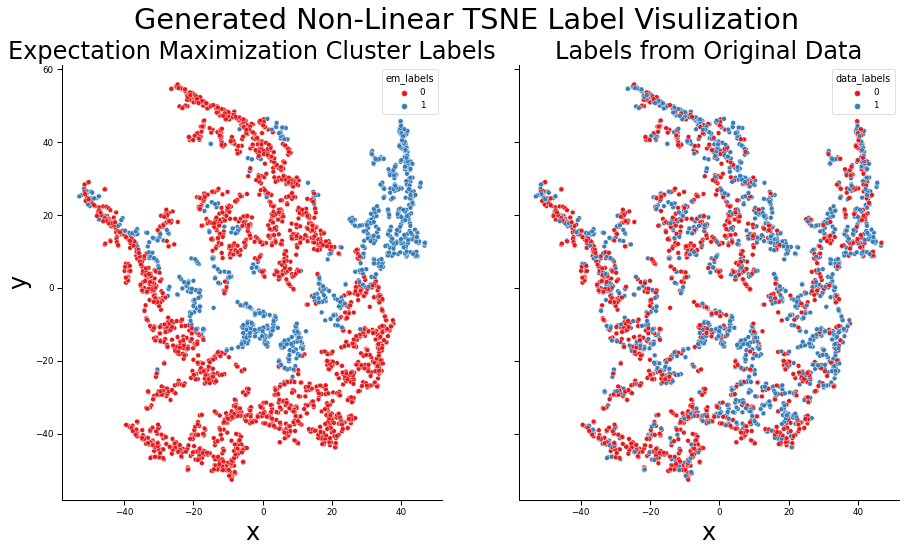

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=default_figure_size, sharey=True)

sns.set_context("paper", rc={"font.size": fontsize, "axes.titlesize": fontsize, "axes.labelsize": fontsize})

sns.scatterplot(x="x", y="y", hue="em_labels", data=y_train_gnnl_df, palette="Set1", ax=ax1)
sns.scatterplot(x="x", y="y", hue="data_labels", data=y_train_gnnl_df, palette="Set1", ax=ax2)

fig.suptitle("{} TSNE Label Visulization".format(DATASET))
ax1.set_title("Expectation Maximization Cluster Labels")
ax2.set_title("Labels from Original Data")
sns.despine(fig)

plt.show()

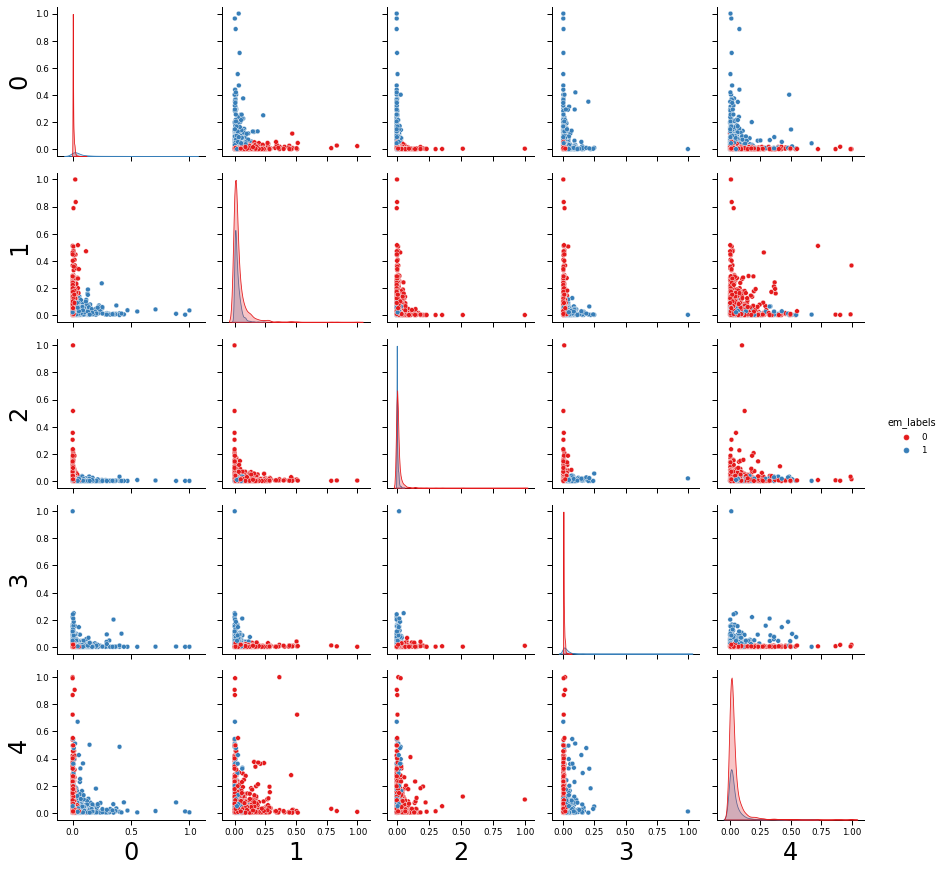

In [25]:
sns.pairplot(boosted_gnnl_em, hue="em_labels", palette="Set1")